In [1]:
!pwd


/mnt/home/eneubeck/GADME


# 1- Loading the model and the dataset

In [2]:
# 1.1 Importe 
# dauert länger

import transformers
import torch

import torch.nn.functional as F
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from torchaudio.transforms import Spectrogram, MelScale

from pytorch_lightning import Callback

from omegaconf import DictConfig

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [3]:
# dauert länger
# !nvidia-smi

In [4]:
print(torch.cuda.is_available())

True


## BirdSet Data Pipeline Tutorial von birdset-pipeline_tutorial.ipynb

### Configuration of BirdSet Data Pipeline

In [5]:
# 1.2 Dataset Configuration

from birdset.datamodule.base_datamodule import DatasetConfig

dataset_config = DatasetConfig(
    data_dir= "/mnt/home/eneubeck/data_birdset",
    dataset_name='HSN',
    hf_path='DBD-research-group/BirdSet',
    hf_name='HSN',
    n_classes=21,
    n_workers=1,
    val_split=0.2,
    task="multilabel",
    subset=None,
    sampling_rate=32000,
    class_weights_sampler=None,
    classlimit=500,
    eventlimit=5,
)


/mnt/home/eneubeck/.conda/envs/explai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/eneubeck/.conda/envs/explai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# 1.3 Dataloader Configuration

from birdset.datamodule.base_datamodule import LoaderConfig, LoadersConfig
# Configuration for the training data loader
train_loader_config = LoaderConfig(
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=False,
    drop_last=True,  # verwirft letzten batch, falls dieser nciht vollständig ist
    persistent_workers=False,
    #prefetch_factor=None,
)

# Configuration for the testing data loader
test_loader_config = LoaderConfig(
    batch_size=32,
    shuffle=False,
    num_workers=8,
    pin_memory=False,
    drop_last=False,
    persistent_workers=False,
    #prefetch_factor=None,
)

# Aggregating the loader configurations
loaders_config = LoadersConfig(
    train=train_loader_config,
    valid=test_loader_config,
    test=test_loader_config,
)

# Loader(s)Config wurde bisher nur so verwendent :     loaders=LoadersConfig(),

In [7]:
# 1.4 Configuration of TransformationsWrapper

from birdset.datamodule.components.transforms import BirdSetTransformsWrapper
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.datamodule.components.transforms import  BirdSetTransformsWrapper, BaseTransforms, PreprocessingConfig
from birdset.datamodule.components.resize import Resizer

from birdset.datamodule.components.augmentations import PowerToDB
from birdset.datamodule.base_datamodule import DatasetConfig, LoadersConfig
from birdset.datamodule.components.event_mapping import XCEventMapping
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor

from torch_audiomentations.core.transforms_interface import BaseWaveformTransform

from omegaconf import DictConfig

# 3.2 Augmentations

from torch_audiomentations import AddColoredNoise, PitchShift
waveform_augmentation = {
    # "multilabel_mix:": MultilabelMix(p=0.3, min_snr_in_db=3.0, max_snr_in_db=30.0, mix_target=union),
    # TODO: wie könnte ich den mulitlabelmix hinzufügen?
    "colored_noise": AddColoredNoise(p=0.2, min_snr_in_db=3.0, max_snr_in_db=30.0, min_f_decay=-2.0, max_f_decay=2.0),
    "pitch_shift": PitchShift(p=0.2, sample_rate=32000, min_transpose_semitones=-4.0, max_transpose_semitones=4.0),
}

from torchvision.transforms import RandomApply
from torchaudio.transforms import TimeMasking, FrequencyMasking
spectrogram_augmentations = {
    # TODO: beide rausnehmen?
    "time_masking": RandomApply([TimeMasking(time_mask_param=100, iid_masks=True)], p=0.3),
    "frequency_masking": RandomApply([FrequencyMasking(freq_mask_param=100, iid_masks=True)], p=0.5)
}

# 3.3 Decoding

from birdset.datamodule.components import EventDecoding
decoding = EventDecoding(
    min_len=1.0,
    max_len=5.0,
    sampling_rate=32000,
    extension_time=8,
    extracted_interval=5,
)

 # 3.4 Feature Extraction

from birdset.datamodule.components import DefaultFeatureExtractor
feature_extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    padding_value=0.0,
    return_attention_mask=False,
)


# 3.5 No-call Sampler

# falls ich das verwenden möchte, müsste ich das tun:
# from birdset.datamodule.components.no_call_sampler import NoCallSampler
#
#nocall_sampler = NoCallMixer(
#    directory: str = "path/to/no_call_samples",  
#    p: float = 0.075,
#    sampling_rate: int = 32000,
#    length: int = 5,
#    n_classes: int = 21,
#)
nocall_sampler = None


# 3.6 Configuration of Data Preprocessing

from torchaudio.transforms import Spectrogram
from birdset.datamodule.components.resize import Resizer
from birdset.datamodule.components.augmentations import PowerToDB
from birdset.datamodule.components.transforms import PreprocessingConfig

# Creating the preprocessing configuration
preprocessing = PreprocessingConfig(
        spectrogram_conversion= Spectrogram(
            n_fft=1024,
            hop_length=128,
            power=2.0,
        ),
        resizer=Resizer(
            db_scale=True,
            target_height=None,
            target_width=1024,
        ),
        dbscale_conversion=PowerToDB(),
        normalize_spectrogram=True,  # TODO?
        normalize_waveform=None,  # TODO? in  config.yaml von efficientnet_HSN#2_2024-02-27_122229 ist normalize_waveform: ${module.network.normalize_waveform}
        mean=4.268, # calculated on AudioSet
        std=4.569 # calculated on AudioSet
    )


# 3.7 Initiating the BirdSetTransformsWrapper
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper

transforms = BirdSetTransformsWrapper(
    task="multilabel",
    sampling_rate=32000,
    model_type="vision",
    spectrogram_augmentations=spectrogram_augmentations,
    waveform_augmentations=waveform_augmentation,
    decoding=decoding,
    feature_extractor=feature_extractor,
    max_length=5,
    nocall_sampler=nocall_sampler,
    preprocessing=preprocessing,
)

In [8]:
# 1.5 Configuration of Event Mappings

from birdset.datamodule.components import XCEventMapping
# Instantiate the event mapper
mapper = XCEventMapping(
            biggest_cluster=True,
            no_call=False,
        )

### Creating the BirdSet Datamodule

In [9]:
# Imports

import logging 
import os

from birdset.datamodule.birdset_datamodule import BirdSetDataModule

In [10]:
# 1.6 Creating Cache Directory

# Log the absolute path of the dataset
logging.info(f"Dataset path: <{os.path.abspath(dataset_config.data_dir)}>")
print("Der absolute Pfad des Datensatz-Verzeichnisses ist:", os.path.abspath(dataset_config.data_dir))

# Create the dataset directory if it does not exist
os.makedirs(dataset_config.data_dir, exist_ok=True)


if os.path.exists(dataset_config.data_dir):
    print(f"Das Verzeichnis existiert: {dataset_config.data_dir}")
else:
    print(f"Das Verzeichnis wurde nicht gefunden: {dataset_config.data_dir}")



Der absolute Pfad des Datensatz-Verzeichnisses ist: /mnt/home/eneubeck/data_birdset
Das Verzeichnis existiert: /mnt/home/eneubeck/data_birdset


In [11]:
# 1.7 Datamodule Initialization

# Initialize the BirdSetDataModule
datamodule = BirdSetDataModule(
        dataset=dataset_config,
        loaders=loaders_config,
        transforms=transforms,
        mapper=mapper,
    )

In [12]:
# 1.8 Data Preparation
# dauert länger

# Prepare the data for training
datamodule.prepare_data()

print("done")

Processing labels: 100%|██████████| 21/21 [00:01<00:00, 11.64it/s]


Map:   0%|          | 0/17940 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14352 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3588 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

done


In [13]:
# TODO: Am Ende schauen: brauch ich das? 
# Datamodule Setup for Training Phase

# Setup the datamodule for the training phase
datamodule.setup(stage="fit")

# Retrieve the training and validation dataloaders
train_loader = datamodule.train_dataloader()
validation_loader = datamodule.val_dataloader()

In [14]:
# TODO: Am Ende schauen: brauch ich das?
# Fetch a sample batch from the training dataloader

for batch in train_loader:
    break

# Inspect the keys and shapes of the data in the batch
batch.keys(), batch["input_values"].shape, batch["labels"].shape

# Ausgabe:
#(dict_keys(['input_values', 'labels']),
# torch.Size([32, 1, 128, 1024]),   # also 32 Bilder, 1 Kanal (Graustufe), Bild Höhe 128, Bild Breite 1024
# torch.Size([32, 21]))             # also 32 Bilder mit je 21 Klassen

(dict_keys(['input_values', 'labels']),
 torch.Size([32, 1, 128, 1024]),
 torch.Size([32, 21]))

In [15]:
# TODO: Am Ende schauen: brauch ich das?
# Datamodule Setup for Test Phase

# Setup the datamodule for the test phase
datamodule.setup(stage="test")

# Retrieve the test dataloader
test_loader = datamodule.test_dataloader()

In [16]:
# 1.9 Evtl. für später: Mapping of Labels to eBird Codes

from typing import Dict

def get_label_to_category_mapping_from_metadata(
    file_path: str, task: str
) -> Dict[int, str]:
    """
    Reads a JSON file and extracts the mapping of labels to eBird codes.

    The function expects the JSON structure to be in a specific format, where the mapping
    is a list of names located under the keys 'features' -> 'labels' -> 'names'.
    The index in the list corresponds to the label, and the value at that index is the eBird code.

    Args:
    - file_path (str): The path to the JSON file containing the label to eBird code mapping.
    - task (str): The type of task for which to get the mapping. Expected values are "multiclass" or "multilabel".

    Returns:
    - Dict[int, str]: A dictionary where each key is a label (integer) and the corresponding value is the eBird code.

    Raises:
    - FileNotFoundError: If the file at `file_path` does not exist.
    - json.JSONDecodeError: If the file is not a valid JSON.
    - KeyError: If the expected keys ('features', 'labels', 'names') are not found in the JSON structure.
    """

    # Open the file and read the JSON data
    with open(file_path, "r") as file:
        dataset_info = json.load(file)

    # Extract the list of eBird codes from the loaded JSON structure.
    # Note: This assumes a specific structure of the JSON data.
    # If the structure is different, this line will raise a KeyError.
    if task == "multiclass":
        ebird_codes_list = dataset_info["features"]["labels"]["names"]
    elif task == "multilabel":
        ebird_codes_list = dataset_info["features"]["labels"]["feature"]["names"]
    else:
        # If the task is not recognized (not multiclass or multilabel), raise an error.
        raise NotImplementedError(
            f"Only the multiclass and multilabel tasks are implemented, not task {task}."
        )

    # Create a dictionary mapping each label (index) to the corresponding eBird code.
    mapping = {label: ebird_code for label, ebird_code in enumerate(ebird_codes_list)}

    return mapping



## Ende des Tutorials

## Spektrogramm

In [17]:
# 1.10 Das erste Beispiel aus dem Dataset erhalten

first_example = batch["input_values"][3]
labels_first_example = batch["labels"][3]
print("first_example", first_example)
print("first_example shape", first_example.shape)
print("labels_first_example", labels_first_example)

# Verwendung von argmax, um den Index des höchsten Werts zu erhalten
top_label_index = torch.argmax(labels_first_example)
print(f"Index des Top-Labels: {top_label_index.item()}")

first_example tensor([[[-2.4912, -2.6443, -3.2369,  ..., -6.5011, -5.5123, -6.3398],
         [-1.3210, -1.4742, -2.0667,  ..., -5.3310, -4.3421, -5.1696],
         [-4.7069, -4.1474, -3.6397,  ..., -3.7224, -3.8850, -3.7946],
         ...,
         [-8.4341, -8.4341, -8.4341,  ..., -7.4723, -7.4114, -7.5524],
         [-8.4341, -8.4341, -8.4341,  ..., -8.1951, -8.3375, -8.4341],
         [-8.4341, -8.4341, -8.4341,  ..., -8.3773, -8.2976, -8.4341]]])
first_example shape torch.Size([1, 128, 1024])
labels_first_example tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=torch.float16)
Index des Top-Labels: 6


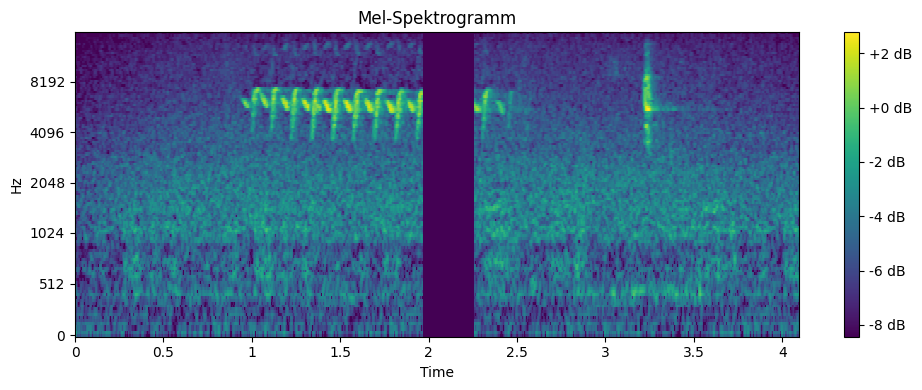

In [18]:
# 1.11 Spektrogramm

import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def show_spektrogrammm2(spektrum, sample_rate, hop_length, n_fft, titel='Mel-Spektrogramm', cmap="viridis"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spektrum, 
                             y_axis='mel', sr=sample_rate, hop_length=hop_length, n_fft=n_fft,  
                             x_axis='time', cmap=cmap)
    plt.colorbar(format='%+2.0f dB')
    plt.title(titel)
    plt.tight_layout()
    plt.show()

n_fft = 1024
hop_length = 128
sample_rate = 32000

# Konvertiere den PyTorch-Tensor in ein NumPy-Array
first_example_np = first_example.numpy()
# Entferne die erste Dimension von ([1, 128, 1397]), da diese nicht benötigt wird:
first_example_np = np.squeeze(first_example_np)

# Rufe die Funktion auf, um das Spektrogramm anzuzeigen
show_spektrogrammm2(first_example_np, sample_rate=sample_rate, hop_length=hop_length, n_fft=n_fft)

In [19]:
# 1.11.a Berechnung der tatsächlichen Dauer

frames = 1024  # Von first_example_np.shape[1]
duration = (frames - 1) * hop_length / sample_rate
print("Tatsächliche Dauer des Spektrogramms: {:.2f} Sekunden".format(duration))
# Tatsächliche Dauer des Spektrogramms: 4.09 Sekunden  
# TODO: warum 4.09s ? Warum nicht 5s?

Tatsächliche Dauer des Spektrogramms: 4.09 Sekunden


In [20]:
# 1.11.b Die höchste Mel-Frequenz

# Berechnen der Mel-Frequenzen
n_mels = 128  # Anzahl der Mel-Bänder, die Sie verwenden (sollte mit Ihrer Transformation übereinstimmen)
# fmax = sample_rate / 2  # Oder jede andere gewünschte obere Frequenzgrenze

mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0)
highest_mel_frequency = mel_frequencies[-1]

print("Die höchste Mel-Frequenz ist:", highest_mel_frequency, "Hz")
# Die höchste Mel-Frequenz ist: 11025.0 Hz

Die höchste Mel-Frequenz ist: 11025.0 Hz


## Das Modell

### von TLDR

In [21]:
# BaseModule von TLDR

from lightning import Trainer
min_epochs = 1
max_epochs = 5
trainer = Trainer(min_epochs=min_epochs, max_epochs=max_epochs, accelerator="gpu", devices=1)


from birdset.modules.base_module import BaseModule
basemodule_model = BaseModule(
    len_trainset=datamodule.len_trainset,
    task=datamodule.task,
    batch_size=datamodule.train_batch_size,
    num_epochs=max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
# BaseModule von TLDR

# trainer.fit(basemodule_model, datamodule)  # `Trainer.fit` stopped: `max_epochs=5` reached.
# 448/448 [02:01<00:00,  3.69it/s, v_num=5425, train/BCEWithLogitsLoss_step=0.178, val/BCEWithLogitsLoss_step=6.510, val/BCEWithLogitsLoss_epoch=0.176, val/cmAP=0.128, train/BCEWithLogitsLoss_epoch=0.177]

In [23]:
#Speichern der Architektur und der trainierten Modellparameter
# torch.save(basemodule_model, 'basemodule_tldr.pth')

# Zum Laden des gesamten Modells 
basemodule_model = torch.load('basemodule_tldr.pth')

In [24]:
# EfficientNet Modell
# dauert länger

# EfficientNetClassifier importieren
from birdset.modules.models.efficientnet import EfficientNetClassifier

# Definition der Parameter
architecture = "efficientnet_b1"  # The version of EfficientNet to use
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern 
# Der Checkpoint meines EfficientNet-Experiments mit den besten Metriken:
checkpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-22_150041/callback_checkpoints/last.ckpt" 

efficientnet_model = EfficientNetClassifier(
    architecture=architecture,
    num_classes=num_classes,
    num_channels=num_channels,
    checkpoint=checkpoint_path)

efficientnet_model = efficientnet_model.eval()
print("done")

>> Found a checkpoint. Loading..
done


In [25]:
"""
# EfficientNet Modell Lightning Versuch
# dauert länger

# EfficientNetClassifier importieren
from birdset.modules.models.efficientnet import EfficientNetClassifier

# Definition der Parameter
architecture = "efficientnet_b1"  # The version of EfficientNet to use
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern 
# Der Checkpoint meines EfficientNet-Experiments mit den besten Metriken:
# checkpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-20_181244/callback_checkpoints/last.ckpt" 
checkpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-22_150041/callback_checkpoints/last.ckpt" 

# Erstellung des Modells über die Wrapper-Klasse
efficientnet_model = EfficientNetLightning(
    EfficientNetClassifier, 
    num_classes, 
    num_channels, 
    checkpoint_path)

#efficientnet_model = EfficientNetClassifier(
#    architecture=architecture,
#    num_classes=num_classes,
#    num_channels=num_channels,
#    checkpoint=checkpoint_path)

efficientnet_model = efficientnet_model.eval()
print("done")
"""

'\n# EfficientNet Modell Lightning Versuch\n# dauert länger\n\n# EfficientNetClassifier importieren\nfrom birdset.modules.models.efficientnet import EfficientNetClassifier\n\n# Definition der Parameter\narchitecture = "efficientnet_b1"  # The version of EfficientNet to use\nnum_classes = 21 # The number of classes for the output layer\nnum_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern \n# Der Checkpoint meines EfficientNet-Experiments mit den besten Metriken:\n# checkpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-20_181244/callback_checkpoints/last.ckpt" \ncheckpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-22_150041/callback_checkpoints/last.ckpt" \n\n# Erstellung des Modells über die Wrapper-Klasse\nefficientnet_model = EfficientNetLightning(\n    EfficientNetClassifier, \n    num_classes, \n    num_channels, \n    checkpoint_path)\n\n#efficientnet_model = EfficientNetClassifier(\n#    architecture=architecture,\n#    num_classes=num_clas

In [26]:
print("DataModule Train DataLoader:", datamodule.train_dataloader())
print("DataModule Validation DataLoader:", datamodule.val_dataloader())
print("DataModule Test DataLoader:", datamodule.test_dataloader())

DataModule Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fe7d9ebf550>
DataModule Validation DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fe7d9ebda50>
DataModule Test DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7fe7d9ebf550>


In [27]:
# Versuch: EfficientNetLighning Modell

"""
import pytorch_lightning as pl
from torchvision import models
import torch
from torch import nn

# EfficientNetClassifier Wrapper-Klasse
class EfficientNetLightning(pl.LightningModule):
    def __init__(self, base_model, num_classes, num_channels=1, checkpoint_path=None):
        super().__init__()
        self.model = base_model(architecture="efficientnet_b1", num_classes=num_classes,
                                num_channels=num_channels, checkpoint=checkpoint_path)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.002)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('test_loss', loss)
        return {"test_loss": loss}


# EfficientNetClassifier importieren
from birdset.modules.models.efficientnet import EfficientNetClassifier

# Definition der Parameter
architecture = "efficientnet_b1"  # The version of EfficientNet to use
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern 
# Der Checkpoint meines EfficientNet-Experiments mit den besten Metriken:
checkpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-20_181244/callback_checkpoints/last.ckpt"

# Erstellung des Modells über die Wrapper-Klasse
efficientnet_lightning_model = EfficientNetLightning(EfficientNetClassifier, num_classes, num_channels, checkpoint_path)
efficientnet_lightning_model = efficientnet_lightning_model.eval()

# Trainer initialisieren
from lightning import Trainer
trainer = Trainer(min_epochs=1, max_epochs=5, accelerator="gpu", devices=1)

print("Type of model before fit:", type(efficientnet_lightning_model))

# Training oder Evaluation optional fortsetzen
trainer.fit(efficientnet_lightning_model, datamodule)
"""

'\nimport pytorch_lightning as pl\nfrom torchvision import models\nimport torch\nfrom torch import nn\n\n# EfficientNetClassifier Wrapper-Klasse\nclass EfficientNetLightning(pl.LightningModule):\n    def __init__(self, base_model, num_classes, num_channels=1, checkpoint_path=None):\n        super().__init__()\n        self.model = base_model(architecture="efficientnet_b1", num_classes=num_classes,\n                                num_channels=num_channels, checkpoint=checkpoint_path)\n    \n    def forward(self, x):\n        return self.model(x)\n    \n    def training_step(self, batch, batch_idx):\n        x, y = batch\n        logits = self(x)\n        loss = nn.functional.cross_entropy(logits, y)\n        self.log(\'train_loss\', loss)\n        return loss\n    \n    def configure_optimizers(self):\n        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.002)\n        return optimizer\n    \n    def test_step(self, batch, batch_idx):\n        x, y = batch\n        logits 

In [28]:
"""
from lightning import Trainer

# Initialize trainer
trainer = Trainer(min_epochs=1, max_epochs=5, accelerator="gpu", devices=1)
"""

'\nfrom lightning import Trainer\n\n# Initialize trainer\ntrainer = Trainer(min_epochs=1, max_epochs=5, accelerator="gpu", devices=1)\n'

In [29]:
"""
# Optionally, continue training from checkpoint or just evaluate
trainer.fit(efficientnet_model, datamodule)
"""

'\n# Optionally, continue training from checkpoint or just evaluate\ntrainer.fit(efficientnet_model, datamodule)\n'

In [30]:
# Modell (basemodule_model) auf dem Validierungsdatensatz testen

val_loader = datamodule.val_dataloader()
trainer.test(basemodule_model, dataloaders=val_loader)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/BCEWithLogitsLoss   │    0.17183472216129303    │
│   test/MultilabelAUROC    │     0.696240246295929     │
│      test/T1Accuracy      │    0.2617056965827942     │
│      test/T3Accuracy      │    0.46125975251197815    │
│         test/cmAP         │    0.12038064002990723    │
│         test/mAP          │    0.20651260018348694    │
└───────────────────────────┴───────────────────────────┘

[{'test/BCEWithLogitsLoss': 0.17183472216129303,
  'test/cmAP': 0.12038064002990723,
  'test/MultilabelAUROC': 0.696240246295929,
  'test/T1Accuracy': 0.2617056965827942,
  'test/T3Accuracy': 0.46125975251197815,
  'test/mAP': 0.20651260018348694}]

In [31]:
"""
# TODO:prüfen, ob das auch für Efficientnet möglich wäre
TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `EfficientNetClassifier`

# Modell (efficientnet_model) auf dem Validierungsdatensatz testen

val_loader = datamodule.val_dataloader()
trainer.test(efficientnet_model, dataloaders=val_loader)

"""

'\n# TODO:prüfen, ob das auch für Efficientnet möglich wäre\nTypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `EfficientNetClassifier`\n\n# Modell (efficientnet_model) auf dem Validierungsdatensatz testen\n\nval_loader = datamodule.val_dataloader()\ntrainer.test(efficientnet_model, dataloaders=val_loader)\n\n'

In [32]:
# 1.11 Wiederholung: Das erste Beispiel aus dem Dataset erhalten

print(first_example)
print(labels_first_example)
print(f"Index des Top-Labels: {top_label_index.item()}")

tensor([[[-2.4912, -2.6443, -3.2369,  ..., -6.5011, -5.5123, -6.3398],
         [-1.3210, -1.4742, -2.0667,  ..., -5.3310, -4.3421, -5.1696],
         [-4.7069, -4.1474, -3.6397,  ..., -3.7224, -3.8850, -3.7946],
         ...,
         [-8.4341, -8.4341, -8.4341,  ..., -7.4723, -7.4114, -7.5524],
         [-8.4341, -8.4341, -8.4341,  ..., -8.1951, -8.3375, -8.4341],
         [-8.4341, -8.4341, -8.4341,  ..., -8.3773, -8.2976, -8.4341]]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=torch.float16)
Index des Top-Labels: 6


In [33]:
# 1.12 Modellvorhersage für ein einzelnes Example Basemodule

import torch
import torch.nn.functional as F

input = first_example.unsqueeze(0)  # fügt neue Dimension an der Position 0 hinzu
# print("input", input)  # input tensor([[[[3.0671, 3.3124, 4.0746,

# Ergebnis der Vorhersage als rohe Ausgabe (Logits)
output = basemodule_model(input)

# Anwenden der Sigmoid-Funktion, um die rohen Modellausgaben in Wahrscheinlichkeiten zw. 0 und 1 umzuwandeln
# Sigmoid, da es eine Multilabel-Klassifizierung ist, und daher jedes Label einzeln einen Wahrscheinlichkeitswert bekommt
output_sigmoid = torch.sigmoid(output)

# Ermitteln des maximalen Werts und des entsprechenden Indexes
prediction_score, pred_label_idx = torch.max(output_sigmoid, dim=1)

top_label = top_label_index.item()
print(top_label)

print("Eingabe:", input)
print("Rohe Ausgabe", output)
print("Ausgabe nach Sigmoid:", output_sigmoid)
print("Höchste Vorhersage:", prediction_score)
print("Index des Labels mit der höchsten Vorhersage:", pred_label_idx) 
print(f"Index des eigentlichen Top-Labels: {top_label_index.item()}")
print("Wert am eigentlichen Top-Labels:", output_sigmoid[0,top_label])

6
Eingabe: tensor([[[[-2.4912, -2.6443, -3.2369,  ..., -6.5011, -5.5123, -6.3398],
          [-1.3210, -1.4742, -2.0667,  ..., -5.3310, -4.3421, -5.1696],
          [-4.7069, -4.1474, -3.6397,  ..., -3.7224, -3.8850, -3.7946],
          ...,
          [-8.4341, -8.4341, -8.4341,  ..., -7.4723, -7.4114, -7.5524],
          [-8.4341, -8.4341, -8.4341,  ..., -8.1951, -8.3375, -8.4341],
          [-8.4341, -8.4341, -8.4341,  ..., -8.3773, -8.2976, -8.4341]]]])
Rohe Ausgabe tensor([[-4.6056, -3.1034, -3.4253, -3.2715, -2.9521, -3.3402, -1.9490, -3.2619,
         -3.5461, -4.1171, -2.6296, -2.4490, -2.3783, -2.1257, -2.1878, -3.9241,
         -2.9134, -2.9294, -3.1561, -2.5770, -3.1096]],
       grad_fn=<AddmmBackward0>)
Ausgabe nach Sigmoid: tensor([[0.0099, 0.0430, 0.0315, 0.0366, 0.0496, 0.0342, 0.1247, 0.0369, 0.0280,
         0.0160, 0.0673, 0.0795, 0.0848, 0.1066, 0.1009, 0.0194, 0.0515, 0.0507,
         0.0409, 0.0706, 0.0427]], grad_fn=<SigmoidBackward0>)
Höchste Vorhersage: tensor([

In [34]:
# 1.12 Modellvorhersage für einen Batch

# Angenommen, 'batch' ist der Batch, den du aus deinem DataLoader erhältst
input_values = batch["input_values"]  # Dies sind die Eingabewerte des Batches

# Lasse den ganzen Batch durch das Modell laufen
output = efficientnet_model(input_values)

# Anwenden der Sigmoid-Funktion, um die rohen Modellausgaben in Wahrscheinlichkeiten zwischen 0 und 1 umzuwandeln
# Dies ist nützlich, da es eine Multilabel-Klassifizierung ist
output_sigmoid = torch.sigmoid(output)

# Ermitteln der maximalen Werte und der entsprechenden Indizes für jedes Beispiel im Batch
# Dies gibt dir die Vorhersage mit der höchsten Wahrscheinlichkeit für jedes Beispiel
prediction_scores, pred_label_idxs = torch.max(output_sigmoid, dim=1)

# Ausgabe der Ergebnisse
# print("Rohe Ausgaben:", output)
# print("Ausgaben nach Sigmoid:", output_sigmoid)
print("Höchste Vorhersagen:", prediction_scores)
print("Indizes der Labels mit den höchsten Vorhersagen:", pred_label_idxs)

Höchste Vorhersagen: tensor([0.7371, 0.7670, 0.7528, 0.7135, 0.7724, 0.6673, 0.8185, 0.8271, 0.8196,
        0.7980, 0.8107, 0.7679, 0.7820, 0.8194, 0.9495, 0.8476, 0.7438, 0.8582,
        0.6588, 0.8397, 0.7598, 0.8623, 0.8989, 0.7341, 0.8049, 0.7349, 0.8868,
        0.8265, 0.7233, 0.6805, 0.7412, 0.8862], grad_fn=<MaxBackward0>)
Indizes der Labels mit den höchsten Vorhersagen: tensor([ 4, 19,  4,  4,  4,  4, 19, 19,  4, 18,  4,  4, 15, 17, 19,  4, 18,  4,
        11,  4, 19, 19, 18,  4, 19, 20,  4,  4,  4,  4,  4, 19])


In [35]:
# Metriken für den batch
from sklearn.metrics import f1_score

# Angenommen, 'labels' sind die tatsächlichen Labels aus deinem Batch
labels = batch["labels"].cpu().numpy()  # Konvertiere die Labels in ein NumPy-Array

# Konvertiere die Sigmoid-Ausgaben in binäre Werte basierend auf einem Schwellenwert (z.B. 0.5)
predicted_labels = (output_sigmoid > 0.5).cpu().numpy()

# Berechne den F1-Score für jedes Label
f1_scores = f1_score(labels, predicted_labels, average=None)

# Berechne den durchschnittlichen F1-Score über alle Labels
average_f1_score = f1_score(labels, predicted_labels, average='macro')

print("F1-Scores für jedes Label:", f1_scores)
print("Durchschnittlicher F1-Score:", average_f1_score)

F1-Scores für jedes Label: [0.         0.28571429 0.         0.         0.06060606 0.
 0.17142857 0.24       0.0952381  0.         0.         0.28571429
 0.43478261 0.         0.16       0.         0.         0.
 0.         0.29411765 0.08695652]
Durchschnittlicher F1-Score: 0.10069324172356688


In [36]:
# Metriken für den batch

# Hier nehmen wir an, dass für jedes Beispiel nur ein "richtiges" Label existiert
correct_predictions = (pred_label_idxs == batch["labels"].argmax(dim=1)).float()
top_1_accuracy = correct_predictions.mean().item()
print("Top-1 Accuracy:", top_1_accuracy)

from sklearn.metrics import average_precision_score

# Berechne AP für jede Klasse und dann den Durchschnitt für den mAP
aps = [average_precision_score(labels[:, i], output_sigmoid.detach().cpu().numpy()[:, i]) for i in range(num_classes)]
map_score = np.mean(aps)
print("mAP:", map_score)

from sklearn.metrics import roc_auc_score
import numpy as np

aucs = []
for i in range(num_classes):
    # Prüfe, ob in der aktuellen Klasse sowohl positive als auch negative Beispiele vorhanden sind
    if len(np.unique(labels[:, i])) > 1:
        auc = roc_auc_score(labels[:, i], output_sigmoid.detach().cpu().numpy()[:, i])
        aucs.append(auc)

# Berechne den durchschnittlichen AUROC, wenn mindestens eine Klasse berechenbar ist
if aucs:
    mean_auroc = np.mean(aucs)
    print("Durchschnittlicher Multilabel-AUROC:", mean_auroc)
else:
    print("Keine Klasse mit ausreichender Variabilität für die Berechnung von AUROC.")

Top-1 Accuracy: 0.0
mAP: 0.1773567136041781
Durchschnittlicher Multilabel-AUROC: 0.6727613547413326


## 2- Gradient-based attribution

Welche Eingabefaktoren (wie Pixel in einem Bild oder Wörter in einem Text) tragen am meisten zu den Vorhersagen des Modells bei?

Der Integrated Gradient interpoliert bei jedem Farbkanal von jedem Pixel in n_steps (z.B. 200) zwischen der Basisfarbe (z.B. schwarz) zur Eingabe (z.B. -0.4226) und untersucht dabei die Veränderung der Vorhersage. Er berechnet für jeden dieser Schritte den Gradienten der Vorhersage in Bezug auf die den Farbkanal des Eingabepixels. 
Der "Gradient" in diesem speziellen Fall (wenn wir uns auf einen Farbkanal eines Pixels konzentrieren) könnte daher als eine Reihe von Skalaren (also Zahlen) betrachtet werden, wobei jeder Skalar die Änderungsrate der Vorhersage bezüglich einer kleinen Änderung im Wert dieses Farbkanals an jedem Interpolationsschritt darstellt. Für die Berechnung des Wertes werden die Skalare summiert und dann vom Pixelwert abgezogen. Wenn wir jedoch über das gesamte Bild und alle Farbkanäle aller Pixel sprechen, ist der Gradient ein hochdimensionaler Vektor, der alle diese partiellen Ableitungen umfasst.
Wenn die Vorhersagewahrscheinlichkeit sich stark erhöht, bekommt der Farbwert des Pixels einen hohen Wert, wenn der Einfluss klein ist, bekommt der Pixel einen niedrigen Wert. Wenn die Vorhersagewahrscheinlichkeit sich verringert, bekommt der Farbwert des Pixels einen negativen Wert.

•	Initialisierung von Integrated Gradients

    Erzeugung des „attributions_ig“-Tensors, der statt jedem Farbwert eines Pixels des input-Tenors einen Attributionswert enthält, der anzeigt, wie die Vorhersage beeinflusst wird.
    Visualisierung des attributions_ig – Tensors
    
•	Anwendung von Noise Tunnel auf Integrated Gradients

    Erzeugung des „attributions_ig_nt“-Tensors, der ein Rauschen auf die Eingabedaten einführt, und dann auf der rauschbehafteten Eingabe die Attributionswerte berechnet.
    -> klarere und möglicherweise aussagekräftigere Visualisierung
    Die Shapley-Werte sind ein Konzept aus der kooperativen Spieltheorie, benannt nach dem Nobelpreisträger Lloyd Shapley. Sie bieten eine Methode, um den Beitrag jedes Spielers in einem kooperativen Spiel zum Gesamtgewinn fair aufzuteilen
    
•	Erstellen einer GradientShap-Instanz, 

    mit einer baseline-Verteilung    
    Berechnung der Attributionswerte    
    Visualisierung der Attributionswerte

In [37]:
# 2.0 der Input-Tensor eines Examples aus dem Batch
input = first_example.unsqueeze(0)
input


tensor([[[[-2.4912, -2.6443, -3.2369,  ..., -6.5011, -5.5123, -6.3398],
          [-1.3210, -1.4742, -2.0667,  ..., -5.3310, -4.3421, -5.1696],
          [-4.7069, -4.1474, -3.6397,  ..., -3.7224, -3.8850, -3.7946],
          ...,
          [-8.4341, -8.4341, -8.4341,  ..., -7.4723, -7.4114, -7.5524],
          [-8.4341, -8.4341, -8.4341,  ..., -8.1951, -8.3375, -8.4341],
          [-8.4341, -8.4341, -8.4341,  ..., -8.3773, -8.2976, -8.4341]]]])

In [38]:
# 2.1 Initialiserung Integrated Gradients und Anwendung auf den input-Tensor
# dauert länger

# initialisiert die Integrated Gradients-Methode mit dem gegebenen Modell (efficientnet_model).
#  Erstellen einer IntegratedGradients Instanz:
integrated_gradients = IntegratedGradients(efficientnet_model)

# wendet die Methode attribute auf eine gegebene Eingabe (den tensor "input") an, um die Wichtigkeit (Attribution) der einzelnen 
# Eingabemerkmale für eine spezifische Zielvorhersage (target=pred_label_idx) zu bestimmen
# Es gibt dabei positive und negative Werte, und es ist keine feste Skala
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


# print(integrated_gradients)  # <captum.attr._core.integrated_gradients.IntegratedGradients object at 0x14d2ad25d660>
print(attributions_ig)  # tensor([[[[ 8.4589e-05,  1.9659e-04,  ...
# print("Attributions-Array-Form:", attributions_ig.squeeze().cpu().detach().numpy().shape)  # (128, 1024)
# print("Input-Array-Form:", input.squeeze().cpu().detach().numpy().shape)  # (128, 1024)

tensor([[[[-6.1048e-05, -1.1866e-04, -7.4997e-05,  ...,  4.6596e-05,
           -2.2118e-05,  2.2367e-06],
          [-1.2694e-06, -7.2385e-05,  6.0246e-05,  ...,  8.0380e-05,
            4.1208e-05, -6.4758e-05],
          [ 6.3925e-05, -1.9028e-04,  1.2302e-04,  ...,  1.2202e-04,
           -1.5617e-05, -9.3075e-06],
          ...,
          [ 1.5244e-04,  1.5487e-03,  6.1892e-04,  ...,  1.8102e-05,
           -1.4237e-05, -5.8391e-05],
          [-6.0690e-04,  1.5835e-03, -7.6795e-04,  ..., -7.6642e-05,
           -1.3302e-05, -6.2832e-05],
          [-6.8887e-04, -2.9728e-04, -1.0625e-03,  ..., -1.4283e-04,
           -1.6436e-06, -4.1460e-05]]]], dtype=torch.float64)


In [39]:
# 2.2 Umformung und Umwandlung des attributions_ig Tensors in einen NumPy-Array

attributions_ig_expanded = np.expand_dims(attributions_ig.squeeze().cpu().detach().numpy(), axis=2)
# print(attributions_ig_expanded)  # [[[-1.39096885e-04]  [-1.89931092e-03]

In [40]:
print(first_example_np.shape)
print(attributions_ig_expanded.shape)

(128, 1024)
(128, 1024, 1)


In [41]:
# Entferne die letzte Dimension, da sie die Größe 1 hat und nicht benötigt wird
attributions_ig_squeezed = np.squeeze(attributions_ig_expanded, axis=-1)
print(attributions_ig_squeezed.shape)

(128, 1024)


In [42]:
# Füge eine Dimension am Ende des 2D-Arrays hinzu, um es zu einem 3D-Array zu machen
attributions_ig_expanded_3d = np.expand_dims(attributions_ig_squeezed, axis=2)
print(attributions_ig_expanded_3d.shape)

(128, 1024, 1)


#### 2.3 Visualization

viz ist aus dem captum.attr.visualization Paket und gehört also zu Captum. 

In [44]:
# wdh
first_example_np.shape

(128, 1024)

In [45]:
# wdh
first_example_np

array([[-2.4911802, -2.644335 , -3.2368839, ..., -6.501138 , -5.5122547,
        -6.339791 ],
       [-1.3210189, -1.4741735, -2.0667224, ..., -5.330977 , -4.342093 ,
        -5.169629 ],
       [-4.706941 , -4.1474347, -3.639743 , ..., -3.7224061, -3.8850343,
        -3.79461  ],
       ...,
       [-8.434055 , -8.434055 , -8.434055 , ..., -7.4723496, -7.411376 ,
        -7.5523677],
       [-8.434055 , -8.434055 , -8.434055 , ..., -8.195097 , -8.337514 ,
        -8.434055 ],
       [-8.434055 , -8.434055 , -8.434055 , ..., -8.377331 , -8.297628 ,
        -8.434055 ]], dtype=float32)

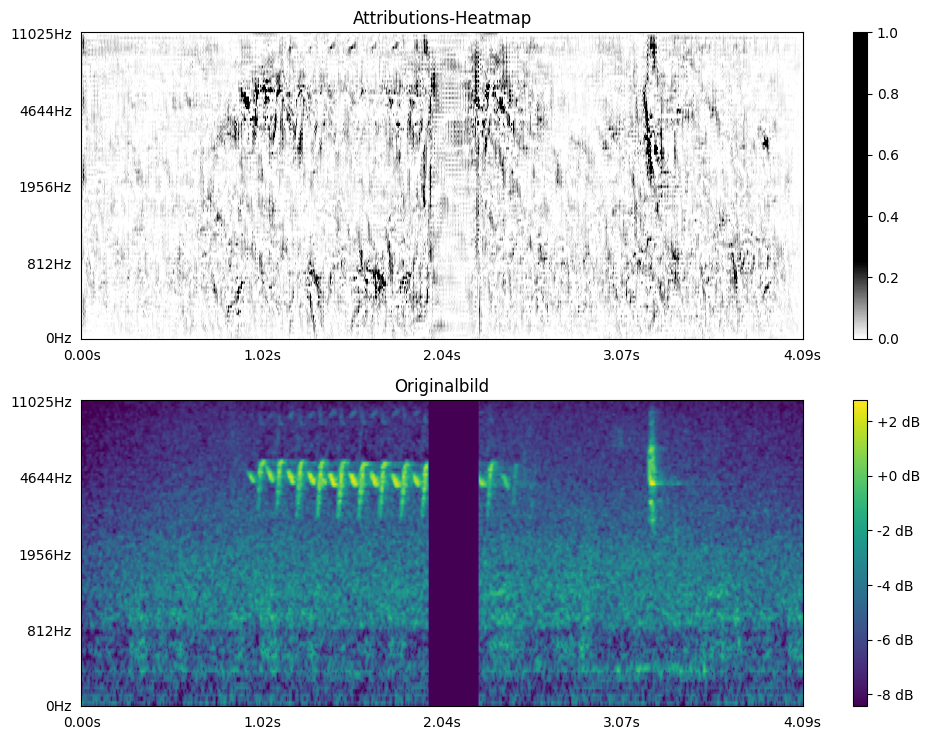

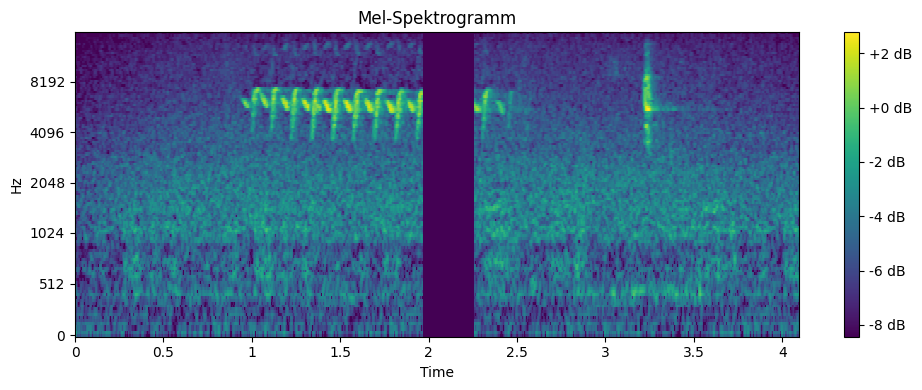

In [65]:
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

# Konfiguration der Farbkarte
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], 
                                                 N=256)

# Erstellung von Subplots
# Breite und Höhe von Heatmap und Originalbild ändern sich, wenn figsize verändert wird 
fig, axs = plt.subplots(2, 1, figsize=(9.4, 7.5))

# Frequenzen für die Mel-Skala generieren
mel_frequencies = librosa.core.mel_frequencies(n_mels=128, fmax=11025)

# Berechnen der Zeitachse für das Spektrogramm
time_axis = librosa.frames_to_time(np.arange(first_example_np.shape[1]), sr=32000, hop_length=128)

# Visualisierung der Attributionswerte (Heatmap)
# Stellen Sie sicher, dass 'attributions_ig_expanded' und 'input' definiert und korrekt sind
viz.visualize_image_attr(attributions_ig_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         cmap=default_cmap,
                         outlier_perc=1,
                         show_colorbar=False)
axs[0].invert_yaxis() 
axs[0].title.set_text('Attributions-Heatmap')
axs[0].set_aspect('auto')

# Manuelle Erstellung einer Colorbar
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="2%", pad=0.5)
plt.colorbar(axs[0].get_images()[0], cax=cax, orientation='vertical')



# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[1].invert_yaxis() 
axs[1].title.set_text('Originalbild')
axs[1].set_aspect('auto')

# Manuelle Erstellung einer Colorbar für das Originalbild
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="2%", pad=0.5)
cb2 = plt.colorbar(axs[1].get_images()[0], cax=cax2, orientation='vertical')
cb2.formatter = FuncFormatter(lambda x, pos: f"{x:+.0f} dB")
cb2.update_ticks()

# Setze die Achsenbeschriftungen für beide Grafiken
for ax in axs:
    # Zeitachse skalieren und formatieren
    ax.set_xticks(np.linspace(0, first_example_np.shape[1] - 1, 5))
    ax.set_xticklabels(['{:.2f}s'.format(t) for t in time_axis[np.linspace(0, len(time_axis) - 1, 5, dtype=int)]])
    # Frequenzachse skalieren und formatieren
    y_ticks = np.linspace(0, 127, 5, dtype=int)  # gleichmäßige Verteilung über die Y-Achse
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(['{:.0f}Hz'.format(m) for m in mel_frequencies[y_ticks]])

plt.tight_layout()
plt.show()

# Korrektes Spektrogramm anzeigen
show_spektrogrammm2(first_example_np, sample_rate=32000, hop_length=128, n_fft=1024)

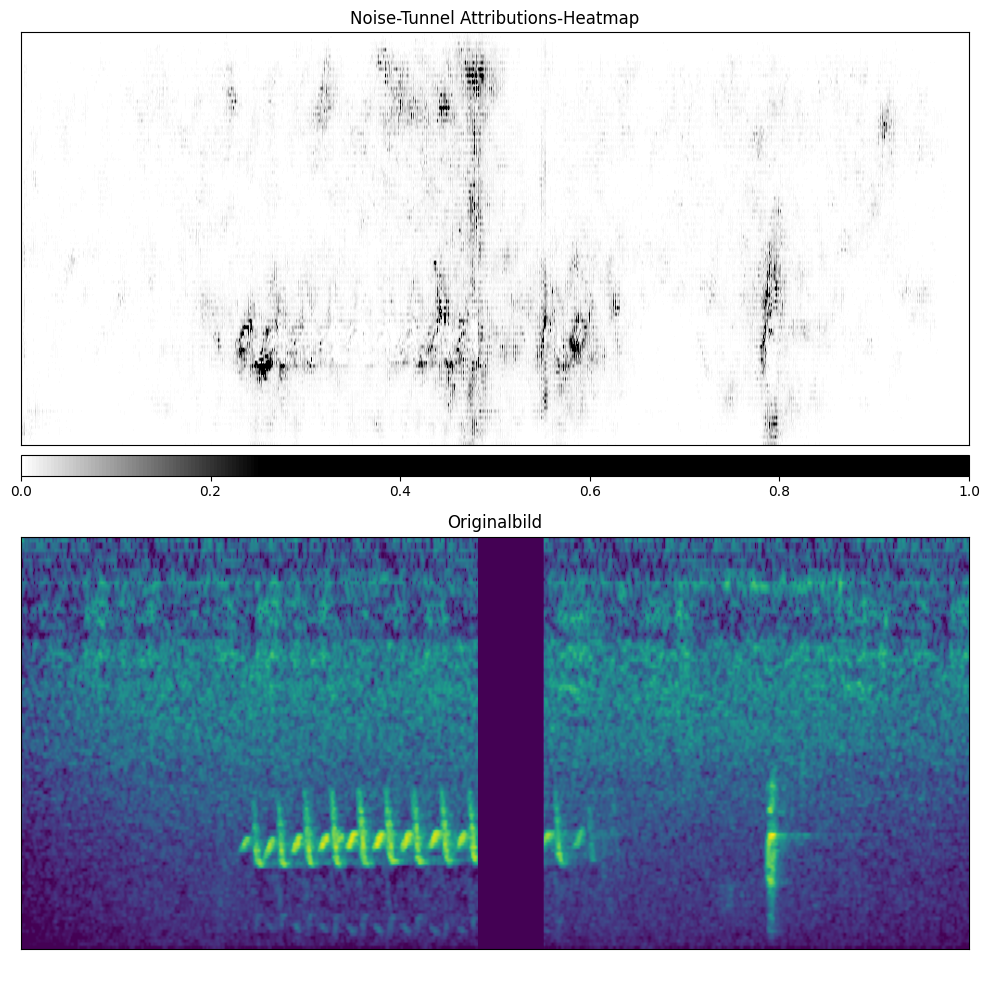

In [47]:
# 2.4 Anwendung von Noise Tunnel auf Integrated Gradients: fügt Rauschen in die Eingabedaten ein
# dauert länger

#  Erstellen einer Noise-Tunnel Instanz:
noise_tunnel = NoiseTunnel(integrated_gradients)

# input ist der tensor eines Examples aus den trainingsdaten
noisetunnel_attributions = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
# print(noisetunnel_attributions)

# 2.2 Umformung (expand) und Umwandlung des attributions_ig Tensors in einen NumPy-Array
noisetunnel_attributions_expanded = np.expand_dims(noisetunnel_attributions.squeeze().cpu().detach().numpy(), axis=2)

# Visualisierung der Noise Tunnel Attributionswerte: 

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Heatmap der Attributionswerte visualisieren
viz.visualize_image_attr(
    noisetunnel_attributions_expanded,
    input.squeeze().cpu().detach().numpy(),
    method="heat_map",
    sign="positive",
    use_pyplot=False,
    plt_fig_axis=(fig, axs[0]),
    cmap=default_cmap,
    show_colorbar=True)
axs[0].title.set_text('Noise-Tunnel Attributions-Heatmap')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(
    None,
    input.squeeze().cpu().detach().numpy(),
    method="original_image",
    use_pyplot=False,
    plt_fig_axis=(fig, axs[1]),
    cmap=default_cmap,
    show_colorbar=True)
axs[1].title.set_text('Originalbild')
axs[1].set_aspect('auto')


plt.tight_layout()
plt.show()

# 3 GradientShap

In [48]:
# 3.1 GradientShap

# Setzen der Zufallssamenfür PyTorch und NumPy (sorgt für Reproduzierbarkeit):
torch.manual_seed(0)
np.random.seed(0)

# Erstellen einer GradientShap-Instanz:
# GradientShap ist eine Erklärungsmethode, die auf der Idee der Shapley-Werte basiert, aber Gradienten verwendet
gradient_shap = GradientShap(efficientnet_model)

# Defining baseline distribution of images
# baseline-Verteilung besteht aus 2 Eingabebildern: input*0 (also schwarzes Bild) und input*1 (unveränderter schwan)
rand_img_dist = torch.cat([input * 0, input * 1])

# Berechnung der Attributionswerte mit GradientShap:
gradientshap_attributions = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
# print("attributions_gs", attributions_gs)  # tensor([[[[-2.8246e-05,  2.7142e-04,  3.7

# 2.2 Umformung (expand) und Umwandlung des gradientshap_attributions Tensors in einen NumPy-Array
gradientshap_attributions_expanded = np.expand_dims(gradientshap_attributions.squeeze().cpu().detach().numpy(), axis=2)


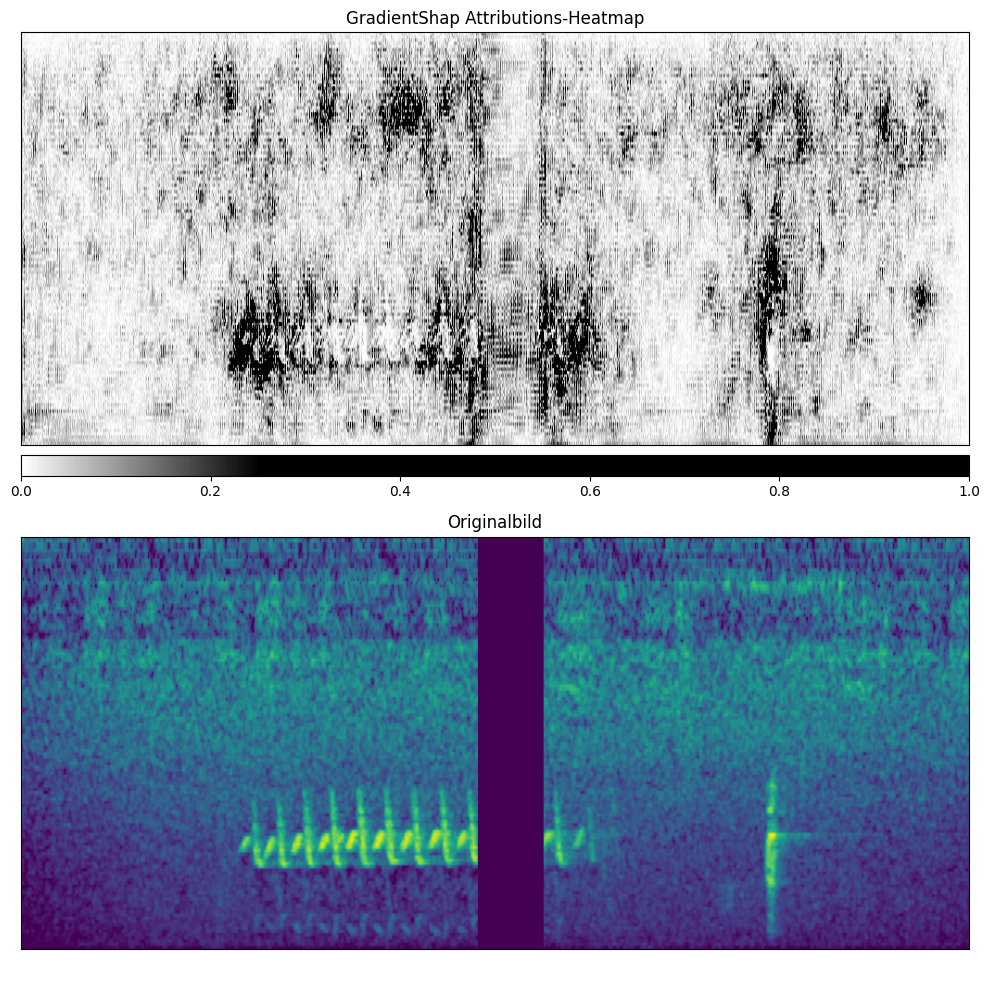

In [49]:
# 3.2 Visualisierung der GradientShap Attributionswerte: 

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Heatmap der Attributionswerte visualisieren
viz.visualize_image_attr(
    gradientshap_attributions_expanded,
    input.squeeze().cpu().detach().numpy(),
    method="heat_map",
    sign="absolute_value",
    use_pyplot=False,
    plt_fig_axis=(fig, axs[0]),
    cmap=default_cmap,
    show_colorbar=True)
axs[0].title.set_text('GradientShap Attributions-Heatmap')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[1].title.set_text('Originalbild')
axs[1].set_aspect('auto')


plt.tight_layout()
plt.show()


# 4- Occlusion-based attribution

Verdeckung von Bildteilen

Abschätzen, welche Bereiche des Bildes für die Entscheidung des Klassifikators kritisch sind, indem wir sie verdecken und quantifizieren, wie sich die Entscheidung ändert.

Technik, die aufzeigt, wie das Entfernen (oder "Verdecken") von Teilen der Eingabedaten die Vorhersage des Modells beeinflusst. Diese Methode hilft dabei zu verstehen, welche Bereiche oder Merkmale der Eingabedaten für die Vorhersagen des Modells besonders wichtig sind.
Kleines verdeckendes Fenster wird über das Bild bewegt. Jedes Mal macht das Modell eine Vorhersage. Die Veränderung des Prediction Scores zeigt, wie wichtig der verdeckte Teil ist.


•	Erstellen einer Occlusion-Instanz

    Berechnung der Attributionswerte für den „attributions_occ“-Tensor
    Visualisierung

•	Erneutes Erstellen der Occlusion-Instanz mit größeren Windows

    Berechnung der Attributionswerte, diesmal strides=(3, 50, 50), sliding_window_shapes=(3, 60, 60)
    Visualisierung


In [50]:
print(input)

tensor([[[[-2.4912, -2.6443, -3.2369,  ..., -6.5011, -5.5123, -6.3398],
          [-1.3210, -1.4742, -2.0667,  ..., -5.3310, -4.3421, -5.1696],
          [-4.7069, -4.1474, -3.6397,  ..., -3.7224, -3.8850, -3.7946],
          ...,
          [-8.4341, -8.4341, -8.4341,  ..., -7.4723, -7.4114, -7.5524],
          [-8.4341, -8.4341, -8.4341,  ..., -8.1951, -8.3375, -8.4341],
          [-8.4341, -8.4341, -8.4341,  ..., -8.3773, -8.2976, -8.4341]]]])


In [51]:
# 4.1 Erstellen einer Occlusion-Instanz:
# dauert länger

occlusion = Occlusion(efficientnet_model)

# Attributionsberechnung:
occlusion_attributions = occlusion.attribute(input,
                                       strides = (1, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,15, 15),
                                       baselines=0)
# print(attributions_occ)

# Umformung (expand) und Umwandlung des attributions_ig Tensors in einen NumPy-Array

occlusion_attributions_expanded = np.expand_dims(occlusion_attributions.squeeze().cpu().detach().numpy(), axis=2)
# print(attributions_occ_expanded)  # [[[ 2.21424055e-05]   [-8.83162433e-05]

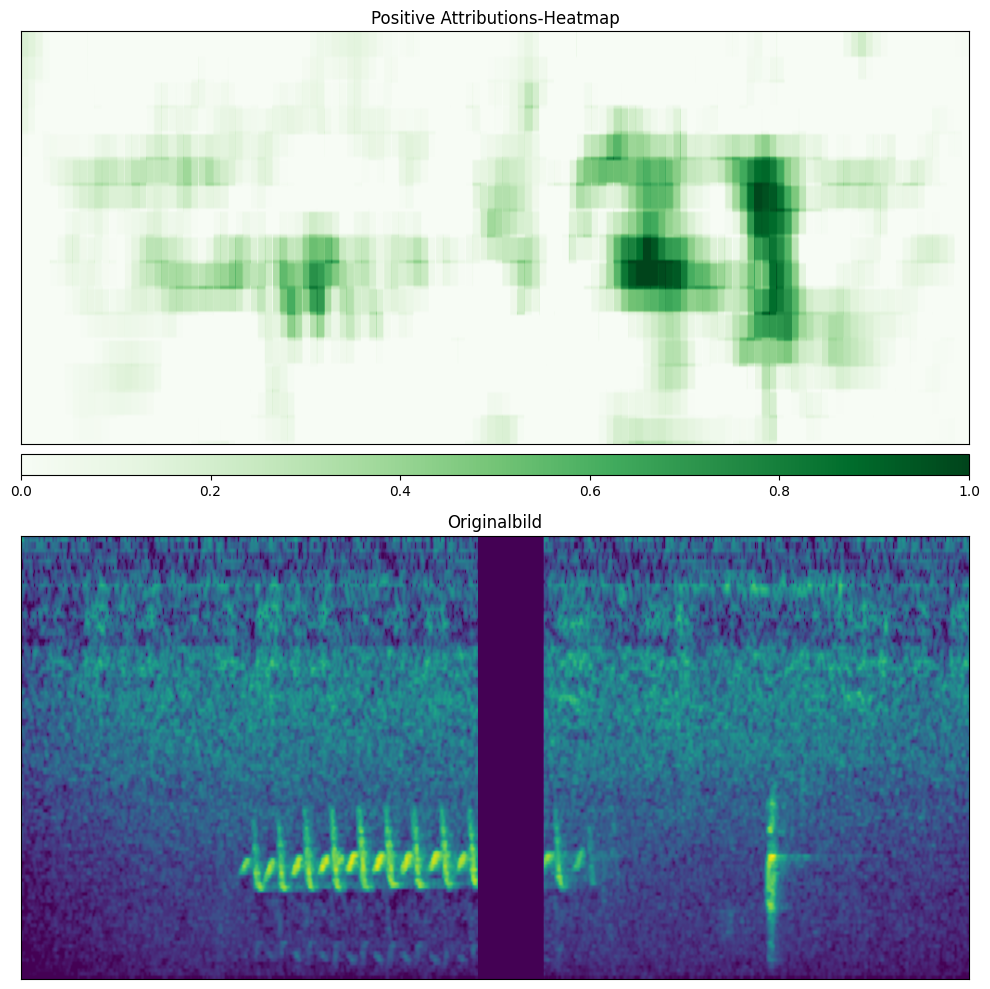

In [52]:
# 4.2 Verwenden einer Visualisierungsfunktion, um mehrere Bildattribute gleichzeitig zu visualisieren

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Erste Heatmap der Attributionswerte visualisieren (z.B. positive Attributionen)
viz.visualize_image_attr(occlusion_attributions_expanded, 
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[0].set_title('Positive Attributions-Heatmap')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap='gray',  # 'gray' funktioniert gut für Graustufenbilder
                         show_colorbar=False)  # Farbleiste ist für das Originalbild normalerweise nicht nötig
axs[1].set_title('Originalbild')
axs[1].set_aspect('auto')

plt.tight_layout()
plt.show()

In [53]:
"""
# 4.2.a Alternative auch mit negativen Werten
# Verwenden einer Visualisierungsfunktion, um mehrere Bildattribute gleichzeitig zu visualisieren

# Figur und Subplots erstellen
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 Zeilen für 3 Plots, 1 Spalte


# Erste Heatmap der Attributionswerte visualisieren (z.B. positive Attributionen)
viz.visualize_image_attr(occlusion_attributions_expanded, 
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[0].set_title('Positive Attributions-Heatmap')
axs[0].set_aspect('auto')


# Zweite Heatmap der Attributionswerte visualisieren (z.B. negative Attributionen)
# Stelle sicher, dass du hier eine andere Attribution verwendest, falls verfügbar
viz.visualize_image_attr(occlusion_attributions_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="negative",  # Annahme, dass dies negative Attributionen darstellt
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[1].set_title('Negative Attributions-Heatmap')
axs[1].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[2]),
                         cmap='gray',  # 'gray' funktioniert gut für Graustufenbilder
                         show_colorbar=False)  # Farbleiste ist für das Originalbild normalerweise nicht nötig
axs[2].set_title('Originalbild')
axs[2].set_aspect('auto')

plt.tight_layout()
plt.show()
"""

'\n# 4.2.a Alternative auch mit negativen Werten\n# Verwenden einer Visualisierungsfunktion, um mehrere Bildattribute gleichzeitig zu visualisieren\n\n# Figur und Subplots erstellen\nfig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 Zeilen für 3 Plots, 1 Spalte\n\n\n# Erste Heatmap der Attributionswerte visualisieren (z.B. positive Attributionen)\nviz.visualize_image_attr(occlusion_attributions_expanded, \n                         input.squeeze().cpu().detach().numpy(),\n                         method="heat_map",\n                         sign="positive",\n                         use_pyplot=False,\n                         plt_fig_axis=(fig, axs[0]),\n                         # cmap=\'inferno\',\n                         show_colorbar=True,\n                         outlier_perc=2)\naxs[0].set_title(\'Positive Attributions-Heatmap\')\naxs[0].set_aspect(\'auto\')\n\n\n# Zweite Heatmap der Attributionswerte visualisieren (z.B. negative Attributionen)\n# Stelle sicher, dass du hier e

In [54]:
"""
# Versuch, den plot in extra-Fenster anzuzeigen

import plotly.express as px
import numpy as np
import torch

import plotly.io as pio
pio.renderers.default = 'notebook'


# Angenommen, attributions_ig_expanded ist dein Tensor mit Attributionswerten
# und 'input' ist dein Eingabebild

# Bereite die Attributionsdaten vor
attributions = attributions_ig_expanded.squeeze()  # Stelle sicher, dass es ein 2D-Array ist
input_image = input.squeeze().cpu().detach().numpy()  # Bereite das Eingabebild vor

# Du möchtest vielleicht die Attributionswerte auf das Eingabebild auftragen
# Hier ein einfaches Beispiel, wie man die Attributionswerte normalisieren und auf das Bild anwenden könnte
# Beachte: Du musst dies an deinen spezifischen Fall anpassen
attributions_normalized = (attributions - attributions.min()) / (attributions.max() - attributions.min())
heatmap = np.uint8(255 * attributions_normalized)  # Konvertiere zu einem 8-Bit-Array für die Darstellung

# Verwende Plotly, um das Bild anzuzeigen
fig = px.imshow(heatmap, color_continuous_scale='Inferno')  # 'Inferno' oder eine andere Farbskala deiner Wahl
fig.show()
"""

"\n# Versuch, den plot in extra-Fenster anzuzeigen\n\nimport plotly.express as px\nimport numpy as np\nimport torch\n\nimport plotly.io as pio\npio.renderers.default = 'notebook'\n\n\n# Angenommen, attributions_ig_expanded ist dein Tensor mit Attributionswerten\n# und 'input' ist dein Eingabebild\n\n# Bereite die Attributionsdaten vor\nattributions = attributions_ig_expanded.squeeze()  # Stelle sicher, dass es ein 2D-Array ist\ninput_image = input.squeeze().cpu().detach().numpy()  # Bereite das Eingabebild vor\n\n# Du möchtest vielleicht die Attributionswerte auf das Eingabebild auftragen\n# Hier ein einfaches Beispiel, wie man die Attributionswerte normalisieren und auf das Bild anwenden könnte\n# Beachte: Du musst dies an deinen spezifischen Fall anpassen\nattributions_normalized = (attributions - attributions.min()) / (attributions.max() - attributions.min())\nheatmap = np.uint8(255 * attributions_normalized)  # Konvertiere zu einem 8-Bit-Array für die Darstellung\n\n# Verwende Plot

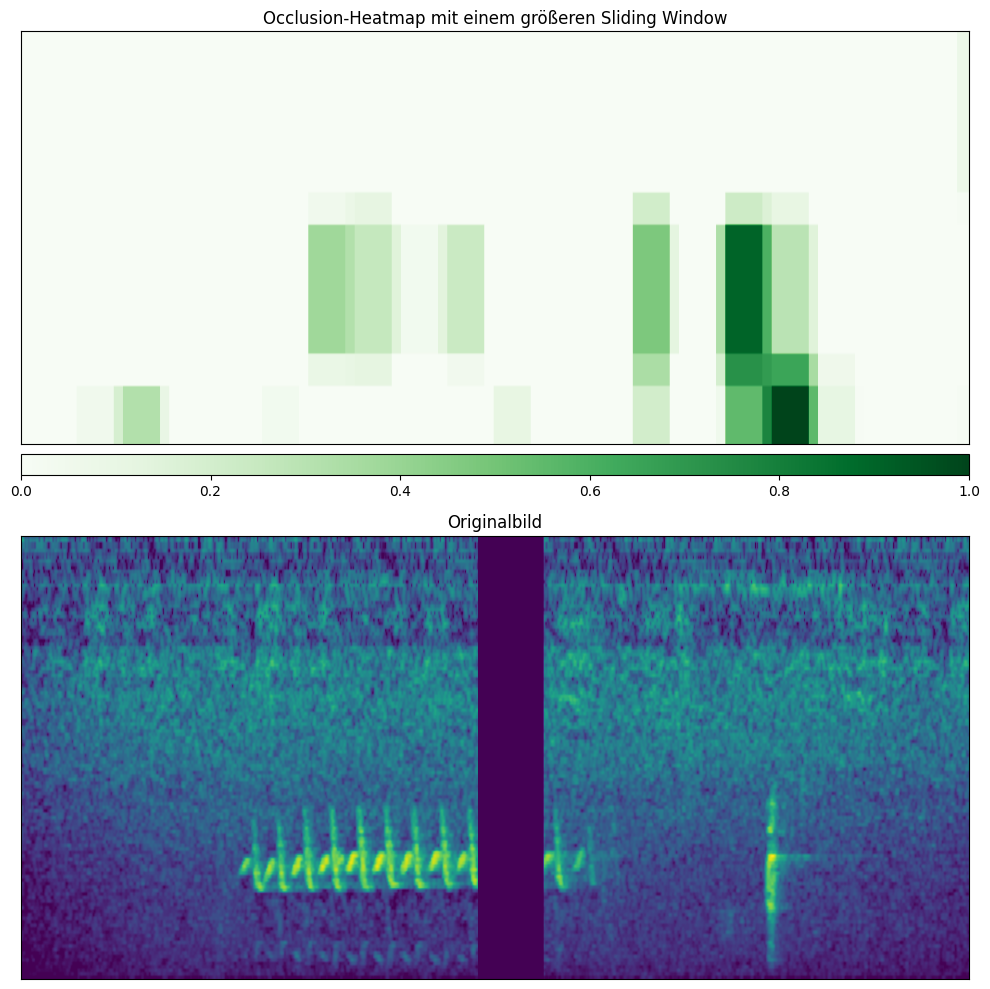

In [55]:
# 4.3 Okklusion mit einem größeren Sliding Window

# occlusion = Occlusion(efficientnet_model)

# Attributionsberechnung:
large_stride_occlusion_attributions = occlusion.attribute(
    input,
    strides = (1, 50, 50),
    target=pred_label_idx,
    sliding_window_shapes=(1,60 , 60),
    baselines=0)
# print(large_stride_occlusion_attributions)

# Umformung (expand) und Umwandlung des attributions_ig Tensors in einen NumPy-Array

large_stride_occlusion_attributions_expanded = np.expand_dims(large_stride_occlusion_attributions.squeeze().cpu().detach().numpy(), axis=2)


# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Erste Heatmap der Attributionswerte visualisieren (z.B. positive Attributionen)

# attributions_ig_expanded? TODO
viz.visualize_image_attr(large_stride_occlusion_attributions_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[0].set_title('Occlusion-Heatmap mit einem größeren Sliding Window')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap='gray',  # 'gray' funktioniert gut für Graustufenbilder
                         show_colorbar=False)  # Farbleiste ist für das Originalbild normalerweise nicht nötig
axs[1].set_title('Originalbild')
axs[1].set_aspect('auto')

plt.tight_layout()
plt.show()